# Knowledge distillation with Transformers

## 1) Models

The teacher (T) model is ViT-B16 (aka DeiT-B), with embedding dimension 768, 12 heads and 12 layers, with a total of 86M params, uses a training resolution of 224x224 and 16 patches (or patch size?). Loaded from: https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html

The model to compare our Proxy Student (PS) is DeiT-S distilled, which has an embedding dimension of 384, 6 heads and 12 layers, with a total of 22M params. Therefore PS will have the same architecture of DeiT-S.

The student (S) can be compared with PS/ or PS with less layers or Deit-Ti (192 embd dim, 3 heads, 12 layers, 5M).

In [2]:
from models.model_hub import *

teacher = ViTB16()
deit_s = DeiT_S16()
proxy_student = ProxyStudent_S16()
deit_ti = DeiT_Ti16()
student = Student_Ti16()

In [3]:
def compute_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
print(f"Teacher: {compute_params(teacher)}")
print(f"DeiT-S: {compute_params(deit_s)}")
print(f"Proxy Student: {compute_params(proxy_student)}")
print(f"DeiT-Ti: {compute_params(deit_ti)}")
print(f"Student: {compute_params(student)}")

Teacher: 86567656
DeiT-S: 22050664
Proxy Student: 25589608
DeiT-Ti: 5717416
Student: 5717416


In [4]:
print(proxy_student)

ProxyStudent_S16(
  (conv_proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  (encoder): modEncoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): ProxyEncoderBlock(
        (ln_1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (cross_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=1536, out_features=384, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): ProxyEncoderBlock(
        (ln_1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (cross_attention): Mul

## 2) Dataset

The dataset that will be used is ImageNet 2012, downloaded from the original website. The metrics to compare will be top-1 and top-5 accuracy.

In [34]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Define the data transforms
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # Do not normalize for visualization purposes
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset = ImageFolder(root="/Users/inaki-eab/Desktop/hupba/repos/vit_kd/data/imagenet/val", transform=val_transforms)

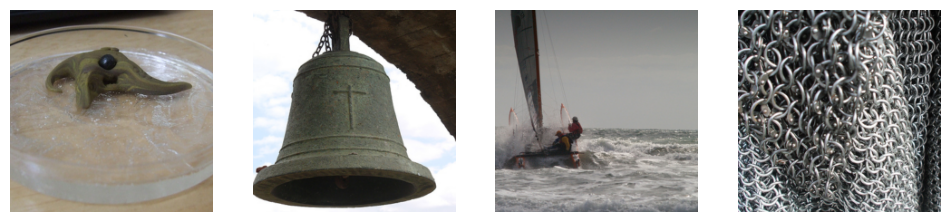

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Select some random images from the dataset
indices = np.random.randint(0, len(val_dataset), size=4)

# Display the images
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
for i, idx in enumerate(indices):
    img, _ = val_dataset[idx]
    ax[i].imshow(np.transpose(np.array(img), (1, 2, 0)))
    ax[i].axis('off')
plt.show()